In [393]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchmetrics
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection 
import torch.utils.data as data 
import numpy as np 
import matplotlib.pyplot as plt

### Get Device for Training

We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.

In [394]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Setting up training data

(1797, 64)


<Figure size 432x288 with 0 Axes>

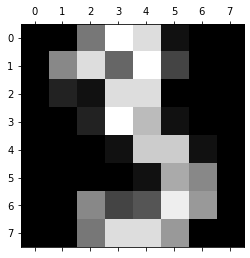

In [395]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

plt.gray()
plt.matshow(digits.images[3])
plt.show()

In [396]:
print(digits.data.shape, digits.target.shape)

(1797, 64) (1797,)


In [397]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, test_size=0.2)

In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators.

In [398]:
X_train = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train = torch.from_numpy(y_train).to().to(device)
y_test = torch.from_numpy(y_test).to().to(device)
X_test = torch.from_numpy(X_test).to(torch.float32).to(device)

### Dataloader

While training a model, we typically want to pass samples in “minibatches”.

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [399]:
from torch.utils import data

class Data(data.Dataset):
	
	def __init__(self, X, Y) -> None:
		super().__init__()

		self.X = X
		self.Y = Y
		
	def __len__(self):
		return len(self.X)

	def __getitem__(self, index):
		_x = self.X[index]
		_y = self.Y[index]

		return _x, _y
	
training_data = Data(X_train, y_train)

### Defining the model Architecture

In [400]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

model

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
)

In [401]:
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00015)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

### Training

In [402]:
accuracy = []
accuracy_test = []
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

print("Epoch = {} \t {} \t {}".format("", "Training Accuracy", "Testing Accuracy"))

for epoch in range(12):

	dataloader = data.DataLoader(training_data, batch_size = 64, shuffle=True)
	
	for d in dataloader:
		
		# calculate current loss
		loss = loss_function(model(d[0]), d[1])
		
		# backpropogation
		model.zero_grad()
		loss.backward()

		# descent
		optimizer.step()

	labels = torch.argmax(model(X_train), dim=1)
	labels_test = torch.argmax(model(X_test), dim=1)

	accuracy.append(metric(labels, y_train).cpu().numpy().item())
	accuracy_test.append(metric(labels_test, y_test).cpu().numpy().item())

	print("Epoch = {} \t {} \t {}".format(epoch, accuracy[-1], accuracy_test[-1]))

	labels.detach()
	labels_test.detach()

Epoch =  	 Training Accuracy 	 Testing Accuracy
Epoch = 0 	 0.13361169397830963 	 0.12222222238779068
Epoch = 1 	 0.19763396680355072 	 0.1944444477558136


Epoch = 2 	 0.2853166460990906 	 0.25555557012557983
Epoch = 3 	 0.3959638178348541 	 0.3611111044883728
Epoch = 4 	 0.49269309639930725 	 0.4861111044883728
Epoch = 5 	 0.581071674823761 	 0.6222222447395325
Epoch = 6 	 0.6694502234458923 	 0.7083333134651184
Epoch = 7 	 0.7146833539009094 	 0.7527777552604675
Epoch = 8 	 0.774530291557312 	 0.8027777671813965
Epoch = 9 	 0.8037578463554382 	 0.8277778029441833
Epoch = 10 	 0.8295059204101562 	 0.8527777791023254
Epoch = 11 	 0.8482950329780579 	 0.8638888597488403


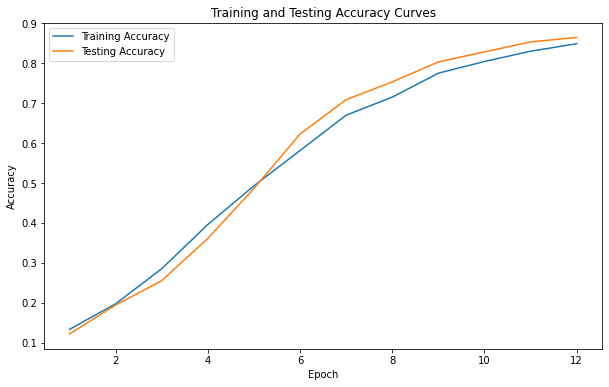

In [403]:
# Plot the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Curves')
plt.legend()
plt.show()

In [404]:
torch.argmax(model(X_test[0]))

tensor(6, device='cuda:0')